#Build CNN Model

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from IPython.display import display, clear_output, HTML
from PIL import Image
from tensorflow.keras import regularizers
import os
import requests
import zipfile
import io
import ipywidgets as widgets
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np


load data augmentasi dari GitHub

In [10]:
# Retrieve data from GitHub and ccreate a temporary path
zip_url = "https://github.com/snapmoo/ML-Dataset/raw/main/FMD_Cattle_Dataset.zip"
zip_path = "/content/FMD_Cattle.zip"

# Download the zip file
response = requests.get(zip_url, stream=True)
with open(zip_path, 'wb') as f:
    for chunk in response.iter_content(chunk_size=8192):
        if chunk:
            f.write(chunk)

# Extract the downloaded Zip file
extract_dir = "/content/FMD_Cattle"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction complete.")

# List the files in the extracted directory to verify
extracted_files = os.listdir(extract_dir)
print("Extracted files:", extracted_files)

base_dir = extract_dir

Extraction complete.
Extracted files: ['test', 'train', 'validation']


Membuat generator train dan validation

In [11]:
# Define the directories for training, validation, and test sets
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Check if the directories exist
print(f"Train directory exists: {os.path.exists(train_dir)}")
print(f"Validation directory exists: {os.path.exists(validation_dir)}")
print(f"Test directory exists: {os.path.exists(test_dir)}")

# Proceed if the train and validation directories exist
if os.path.exists(train_dir) and os.path.exists(validation_dir):
    # Data augmentation and rescaling for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Only rescaling for validation
    validation_datagen = ImageDataGenerator(
        rescale=1./255
    )

    test_datagen = ImageDataGenerator(
        rescale=1./255
    )

    # Create generators
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary'
    )

    validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary'
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary'
    )
    # Debug: Check the first batch of training data
    x_batch, y_batch = next(train_generator)
    print("Shape of training data batch:", x_batch.shape)
    print("Shape of training labels batch:", y_batch.shape)

    # Debug: Check the first batch of validation data
    x_val_batch, y_val_batch = next(validation_generator)
    print("Shape of validation data batch:", x_val_batch.shape)
    print("Shape of validation labels batch:", y_val_batch.shape)
else:
    print("Train or validation directory does not exist. Please check the dataset structure.")

Train directory exists: True
Validation directory exists: True
Test directory exists: True
Found 211 images belonging to 2 classes.
Found 45 images belonging to 2 classes.
Found 47 images belonging to 2 classes.
Shape of training data batch: (32, 224, 224, 3)
Shape of training labels batch: (32,)
Shape of validation data batch: (32, 224, 224, 3)
Shape of validation labels batch: (32,)


Membangun Model CNN

In [13]:
from keras.applications import VGG16
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras import regularizers
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Memuat model dasar VGG16 tanpa lapisan atas (include_top=False)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Membekukan lapisan-lapisan dari model dasar
for layer in base_model.layers:
    layer.trainable = False

# Membuat model baru dengan menambahkan lapisan-lapisan di atas model dasar
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Kompilasi model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Callbacks untuk early stopping dan model checkpoint



# Pelatihan model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)


Epoch 1/50
6/6 [==============================] - 4s 438ms/step - loss: 3.4239 - accuracy: 0.5417 - val_loss: 2.3078 - val_accuracy: 0.5000
Epoch 2/50
6/6 [==============================] - 4s 613ms/step - loss: 1.3481 - accuracy: 0.6592 - val_loss: 1.9800 - val_accuracy: 0.5938
Epoch 3/50
6/6 [==============================] - 2s 394ms/step - loss: 1.4269 - accuracy: 0.6983 - val_loss: 0.3382 - val_accuracy: 0.8438
Epoch 4/50
6/6 [==============================] - 3s 421ms/step - loss: 0.6516 - accuracy: 0.8045 - val_loss: 0.1438 - val_accuracy: 0.8750
Epoch 5/50
6/6 [==============================] - 3s 427ms/step - loss: 0.7633 - accuracy: 0.7821 - val_loss: 0.1577 - val_accuracy: 0.9062
Epoch 6/50
6/6 [==============================] - 3s 404ms/step - loss: 0.4847 - accuracy: 0.8436 - val_loss: 0.1391 - val_accuracy: 0.9062
Epoch 7/50
6/6 [==============================] - 3s 420ms/step - loss: 0.4093 - accuracy: 0.8380 - val_loss: 0.1487 - val_accuracy: 0.9062
Epoch 8/50
6/6 [====

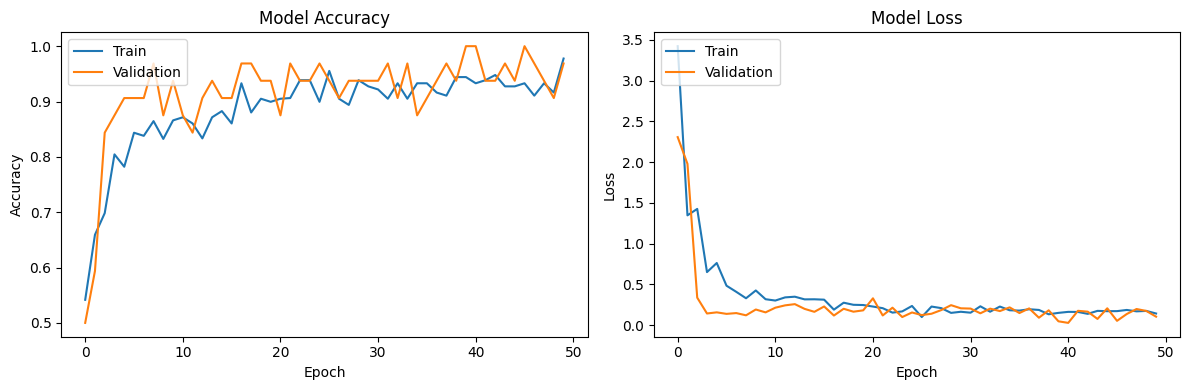

In [16]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

predict

In [8]:
def on_upload_change(change):
    clear_output(wait=True)

    # Proses file yang diunggah
    if change['new']:
        for name, file_info in change['new'].items():
            file_content = file_info['content']
            img = Image.open(io.BytesIO(file_content))

            # Tampilkan gambar yang diunggah
            display(HTML("<h3>Uploaded Image:</h3>"))
            display(widgets.Image(value=file_content, format='jpg'))

            # Prediksi gambar
            pmk_label, pmk_confidence= process_and_predict(img)

            if pmk_label is None:
                display(HTML('<p style="color:red;">Error processing the image.</p>'))
            else:
                display(HTML(f"<h3>Prediction Result:</h3>"))
                display(HTML(f"<p>PMK Prediction: <strong>{pmk_label}</strong> ({pmk_confidence * 100:.2f}% confidence)</p>"))


In [9]:
def process_and_predict(image):
    try:
        # Resize dan preprocess gambar
        img = image.resize((224, 224))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Lakukan prediksi
        predictions = model.predict(img_array)

        # Debug print untuk memeriksa prediksi mentah
        print("Predictions:", predictions)

        # Prediksi PMK
        pmk_pred = predictions[0][0]
        pmk_label = 'Terkena PMK' if pmk_pred > 0.5 else 'Tidak terkena PMK'
        pmk_confidence = pmk_pred if pmk_pred > 0.5 else 1 - pmk_pred

        return pmk_label, float(pmk_confidence)
    except Exception as e:
        print(f"Error: {e}")
        return None, None

In [18]:
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)
upload_widget.observe(on_upload_change, names='value')

display(HTML("<h2>Upload Image to Predict PMK and Body Part</h2>"))
display(upload_widget)

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xed\x01\xb0Photoshop 3.0\x008…

1/1 [==============================] - 0s 20ms/step
Predictions: [[7.115068e-06]]


In [15]:
import os
from keras.preprocessing.image import load_img, img_to_array

def process_and_predict(image_path):
    try:
        # Load dan resize gambar
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Lakukan prediksi
        predictions = model.predict(img_array)

        # Prediksi PMK
        pmk_pred = predictions[0][0]
        pmk_label = 'Terkena PMK' if pmk_pred > 0.5 else 'Tidak terkena PMK'
        pmk_confidence = pmk_pred if pmk_pred > 0.5 else 1 - pmk_pred

        return pmk_label, float(pmk_confidence)
    except Exception as e:
        print(f"Error: {e}")
        return None, None

# Predict all images in the test folder
test_folder = os.path.dirname(test_generator.filepaths[0])  # Assuming all images are in the same directory
image_files = test_generator.filepaths

for image_file in image_files:
    label, confidence = process_and_predict(image_file)
    print(f"File: {image_file} - Predicted: {label} with confidence: {confidence}")


1/1 [==============================] - 0s 131ms/step
File: /content/FMD_Cattle/test/0/img126.jpeg - Predicted: Tidak terkena PMK with confidence: 0.9997643746901304
1/1 [==============================] - 0s 17ms/step
File: /content/FMD_Cattle/test/0/img127.jpeg - Predicted: Tidak terkena PMK with confidence: 0.9956975001841784
1/1 [==============================] - 0s 17ms/step
File: /content/FMD_Cattle/test/0/img128.jpeg - Predicted: Tidak terkena PMK with confidence: 0.9703698717057705
1/1 [==============================] - 0s 19ms/step
File: /content/FMD_Cattle/test/0/img129.jpeg - Predicted: Tidak terkena PMK with confidence: 0.9990953170345165
1/1 [==============================] - 0s 24ms/step
File: /content/FMD_Cattle/test/0/img130.jpeg - Predicted: Tidak terkena PMK with confidence: 0.9999965863225952
1/1 [==============================] - 0s 18ms/step
File: /content/FMD_Cattle/test/0/img131.jpeg - Predicted: Tidak terkena PMK with confidence: 0.9918814906850457
1/1 [==========

In [17]:
model.save('model.h5')
print("Model disimpan sebagai model.h5")

# Menyimpan model dalam format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_model_path = 'model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)
print(f"Model disimpan sebagai {tflite_model_path}")

# Menyimpan arsitektur model dalam format JSON
model_json = model.to_json()
json_model_path = 'model.json'
with open(json_model_path, 'w') as json_file:
    json_file.write(model_json)
print(f"Arsitektur model disimpan sebagai {json_model_path}")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model disimpan sebagai model.h5
Model disimpan sebagai model.tflite
Arsitektur model disimpan sebagai model.json
